## Low Dose CT with HDF5

In [1]:
import time
start = time.time()

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
sys.path.append("..")

In [4]:
from util import show, plot_images, plot_tensors

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk
from skimage.filters import gaussian, median
from skimage import data, img_as_float, img_as_ubyte
from skimage.color import gray2rgb
from skimage.util import random_noise
from skimage.measure import compare_psnr,compare_ssim,compare_mse
import numpy as np
import h5py

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [6]:
f = h5py.File('ground_truth_train_005.hdf5', 'r')
image = f['data']
image = np.reshape(image[15], (362,362))


In [7]:
#plt.rc('figure', figsize = (5,5))
np.random.seed(3)
noisy_image = random_noise(image, mode = 'gaussian', var=0.0001) #sigma = 0.3


In [8]:
import torch
noisy = torch.Tensor(noisy_image[np.newaxis, np.newaxis])

from mask import Masker
masker = Masker(width = 4, mode='interpolate')

torch.manual_seed(3)
from models.dncnn import DnCNN
model = DnCNN(1, num_of_layers = 8)

sum(p.numel() for p in model.parameters() if p.requires_grad)

image.ravel().shape


(131044,)

In [9]:
from torch.nn import MSELoss, CrossEntropyLoss, L1Loss
#from torch.nn import HuberLoss
from torch.optim import Adagrad
loss_function = MSELoss()
#loss_function = CrossEntropyLoss()
optimizer = Adagrad(model.parameters(), lr=0.01)
#optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9)
#model = model.to(device)
#noisy = noisy.to(device)

In [10]:
losses = []
val_losses = []
best_images = []
best_val_loss = 1

for i in range(500):
    model.train()
    
    net_input, mask = masker.mask(noisy, i % (masker.n_masks - 1))
    net_output = model(net_input)
    
    loss = loss_function(net_output*mask, noisy*mask)
    optimizer.zero_grad()
 
    loss.backward()
    
    optimizer.step()
    
    if i % 10 == 0:
        losses.append(loss.item())
        model.eval()
        
        net_input, mask = masker.mask(noisy, masker.n_masks - 1)
        net_output = model(net_input)
    
        val_loss = loss_function(net_output*mask, noisy*mask)
        
        val_losses.append(val_loss.item())
        
        print("(", i, ") Loss: \t", round(loss.item(), 5), "\tVal Loss: \t", round(val_loss.item(), 5))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            denoised = np.clip(model(noisy).detach().cpu().numpy()[0, 0], 0, 1).astype(np.float64)
            best_psnr = compare_psnr(denoised, image)
            best_images.append(denoised)
            print("\tModel PSNR: ", np.round(best_psnr, 2))

( 0 ) Loss: 	 0.01184 	Val Loss: 	 0.12037


C:\Users\shali\Anaconda3\lib\site-packages\skimage\measure\simple_metrics.py:127: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


	Model PSNR:  4.48
( 10 ) Loss: 	 0.00022 	Val Loss: 	 0.00138
	Model PSNR:  16.5
( 20 ) Loss: 	 0.00018 	Val Loss: 	 0.00094
	Model PSNR:  18.17
( 30 ) Loss: 	 0.00015 	Val Loss: 	 0.00057
	Model PSNR:  20.29
( 40 ) Loss: 	 0.0001 	Val Loss: 	 0.00028
	Model PSNR:  23.29
( 50 ) Loss: 	 0.00012 	Val Loss: 	 0.00012
	Model PSNR:  26.84
( 60 ) Loss: 	 0.00011 	Val Loss: 	 9e-05
	Model PSNR:  28.03
( 70 ) Loss: 	 8e-05 	Val Loss: 	 8e-05
	Model PSNR:  28.57
( 80 ) Loss: 	 0.0001 	Val Loss: 	 8e-05
	Model PSNR:  28.85
( 90 ) Loss: 	 9e-05 	Val Loss: 	 7e-05
	Model PSNR:  29.05
( 100 ) Loss: 	 7e-05 	Val Loss: 	 7e-05
	Model PSNR:  29.24
( 110 ) Loss: 	 9e-05 	Val Loss: 	 7e-05
	Model PSNR:  29.4
( 120 ) Loss: 	 8e-05 	Val Loss: 	 7e-05
	Model PSNR:  29.55
( 130 ) Loss: 	 6e-05 	Val Loss: 	 7e-05
	Model PSNR:  29.71
( 140 ) Loss: 	 8e-05 	Val Loss: 	 6e-05
	Model PSNR:  29.83
( 150 ) Loss: 	 7e-05 	Val Loss: 	 6e-05
	Model PSNR:  29.95
( 160 ) Loss: 	 6e-05 	Val Loss: 	 6e-05
	Model PSNR:  

C:\Users\shali\Anaconda3\lib\site-packages\skimage\measure\_structural_similarity.py:155: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


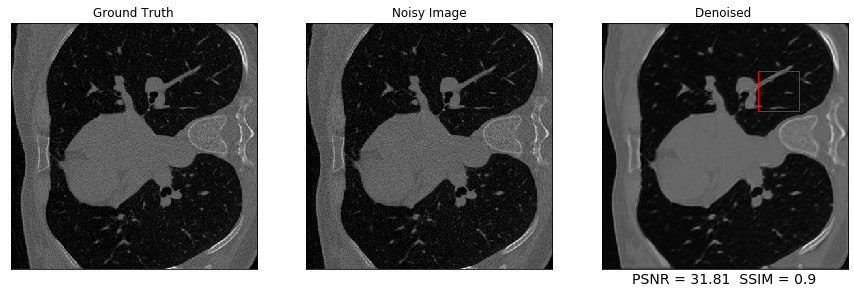

In [11]:
denoised = best_images[-1]

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))

for ax, img, title in zip(axes,
                          [image, noisy_image, denoised],
                          ['Ground Truth','Noisy Image', 'Denoised ']):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.set_yticks([])
    ax.set_xticks([])
    
    
rect = Rectangle((230,70),60,60, edgecolor='r', facecolor="none")
ax.set_xlabel('PSNR = ' + str(round(compare_psnr(denoised, image),2)) + '  SSIM = ' + str(round(compare_ssim(denoised, image),2)),fontsize = 14) #, fontweight ='bold')
ax.add_patch(rect)


In [12]:
print("MSE = ", round(compare_mse(denoised, image),4))

MSE =  0.0007


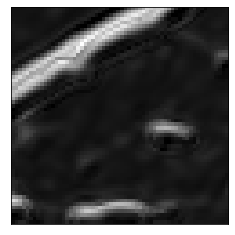

In [13]:
x1 = 70
x2 = 130
y1 = 230
y2 = 290
get_inset = lambda x: x[x1:x2, y1:y2]
show(get_inset(denoised))

In [14]:
stop = time.time()
elapsed = stop - start
print(elapsed)

5329.278565406799
